In [ ]:
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!pip install -q tellurium
!pip install -q SBstoat

In [ ]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te
import itertools
import os
import scipy
from scipy import fftpack
import urllib.request # use this library to download file from GitHub
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter


In [ ]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2107290002/2/Alharbi2020.xml"

model = te.loadSBMLModel(URL)


print(model.getAntimony())


// Created by libAntimony v2.13.4
function Rate_Law_for_Normal_cell_growth(r, N, beta_1)
  r*N*(1 - beta_1*N);
end

Rate_Law_for_Normal_cell_growth is "Rate Law for Normal_cell_growth"

function Rate_Law_for_Normal_cell_death_inhibition(eta, N, I, gamma_, T)
  eta*N*I + gamma_*N*T;
end

Rate_Law_for_Normal_cell_death_inhibition is "Rate Law for Normal_cell_death/inhibition"

function Rate_Law_for_Tumor_cell_growth(alpha_1, T, alpha_2, beta_2, N)
  alpha_1*T*(1 - alpha_2*T) + beta_2*N*T;
end

Rate_Law_for_Tumor_cell_growth is "Rate Law for Tumor_cell_growth"

function Rate_Law_for_Tumor_cell_death_inhibition(alpha_3, T, I)
  alpha_3*T*I;
end

Rate_Law_for_Tumor_cell_death_inhibition is "Rate Law for Tumor_cell_death/inhibition"

function Rate_Law_for_Immune_cell_increase(sigma, rho, N, I, m, rho_1, T, m_1)
  sigma + rho*N*I/(m + N) + rho_1*T*I/(m_1 + T);
end

Rate_Law_for_Immune_cell_increase is "Rate Law for Immune_cell_increase"

function Rate_Law_for_Immune_cell_decrease(delta, I, mu

Regenerated key figure 1 in paper, then added noise with synthetic data. Then I calculated parameter variances and R2 values for each standard deviation value.


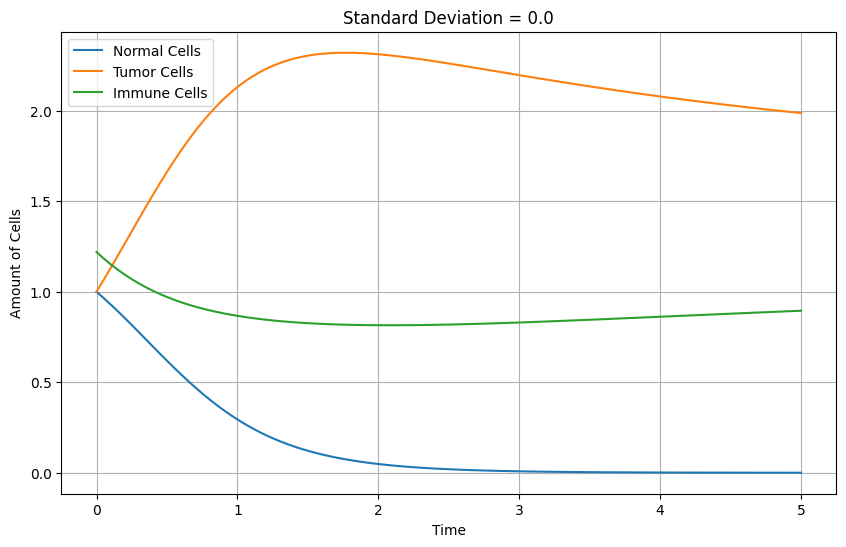

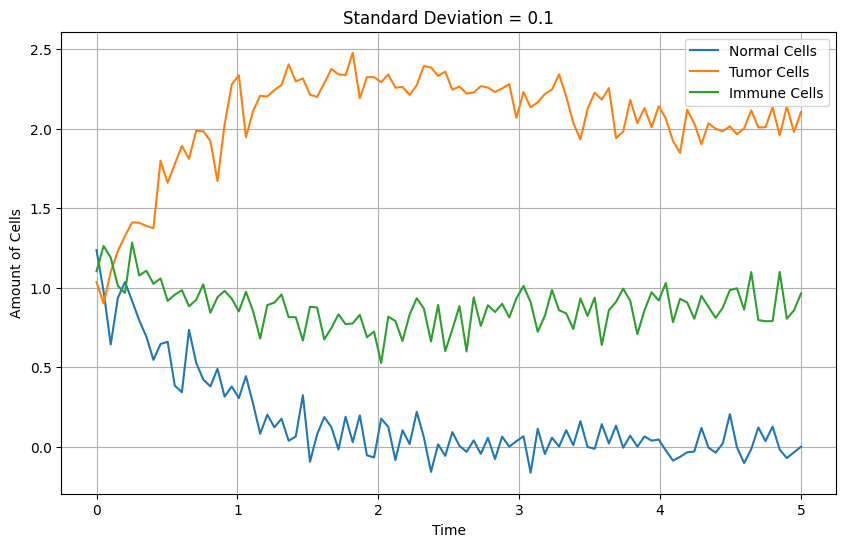

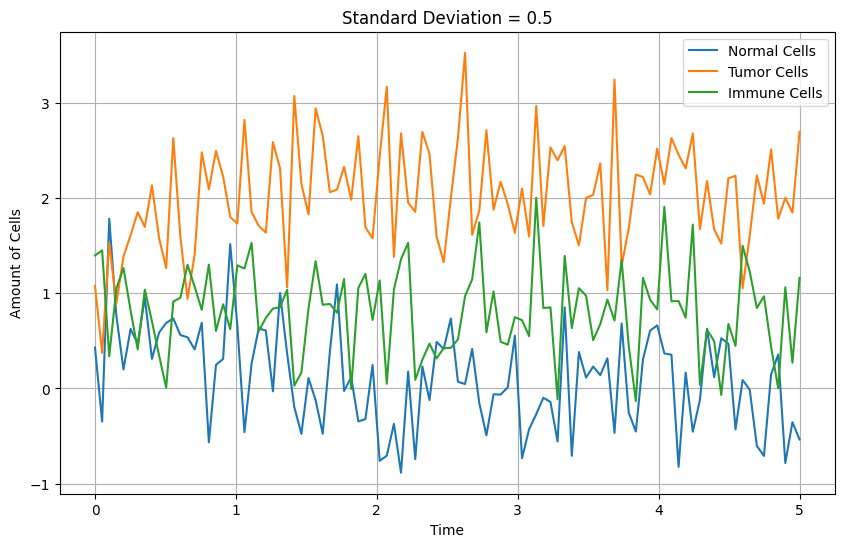

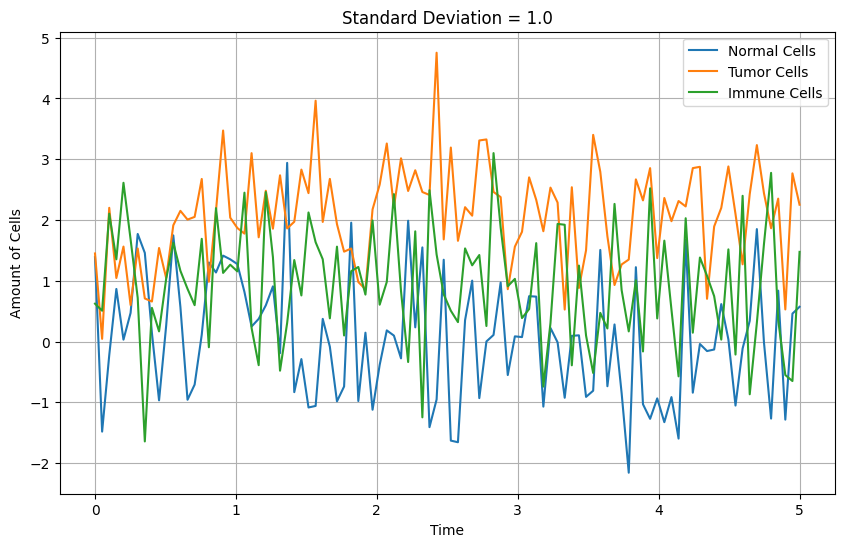

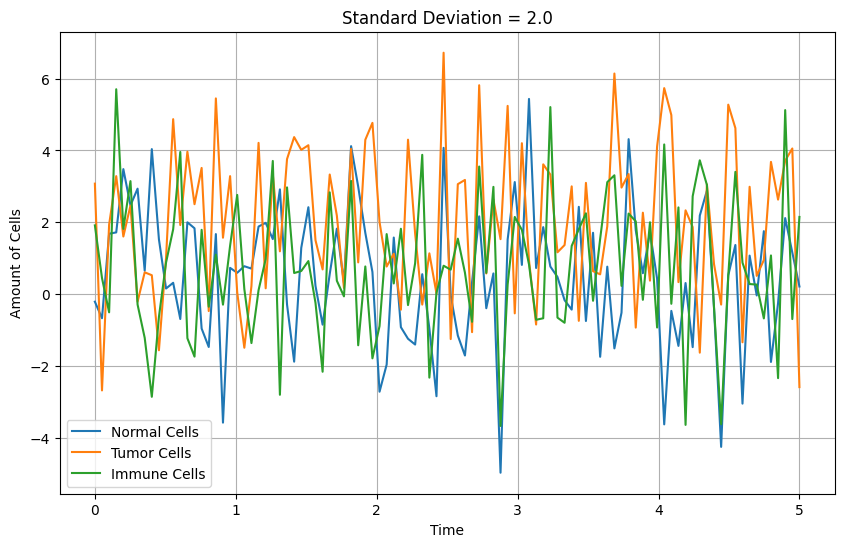

In [ ]:
def generateNoisyData(model, std_dev):
    model.reset()
    result = model.simulate(0, 5, 100, ['Time', 'Normal_cells', 'Tumor_cells', 'Immune_cells'])
    time = result[:, 0]
    species_data = result[:, 1:]
    noise = np.random.normal(0, std_dev, species_data.shape)
    noisy_data = species_data + noise
    noisy_result = np.column_stack((time, noisy_data))

    # Convert the noisy_result to a NamedTimeseries object
    noisy_timeseries = SBstoat.NamedTimeseries(array=noisy_result, colnames=['Time', 'Normal_cells', 'Tumor_cells', 'Immune_cells'])

    return noisy_timeseries


TIME = "time"

# Define a list of standard deviations to consider
std_devs = [0.0, 0.1, 0.5, 1.0, 2.0]

# Generate synthetic data for each standard deviation
synthetic_data = {}
for std_dev in std_devs:
    model.reset()
    noisy_data = generateNoisyData(model, std_dev)
    synthetic_data[std_dev] = noisy_data

# Function to plot the data
def plot_data(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['Normal_cells'], label='Normal Cells')
    plt.plot(data['Time'], data['Tumor_cells'], label='Tumor Cells')
    plt.plot(data['Time'], data['Immune_cells'], label='Immune Cells')
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

std_devs_to_plot = std_devs

for std_dev in std_devs_to_plot:
    data = synthetic_data[std_dev]
    title = f'Standard Deviation = {std_dev}'
    ylabel = 'Amount of Cells'
    plot_data(data, title, ylabel)


In [ ]:
FitterInfo = collections.namedtuple("FitterInfo", "rssq num_eval fitter max_err median_err")

def getFitterInfo(fitter):
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    # Get statistics on the fit
    fitter.roadrunnerModel.resetAll()
    parameter_value_dct = getParameterValueDct(fitter.roadrunnerModel.getAntimony())
    errs = []
    for key, value in fitter.params.valuesdict().items():
        err = np.abs(value - parameter_value_dct[key])/parameter_value_dct[key]
        errs.append(err)
    max_err = max(errs)
    median_err = np.median(errs)

    return FitterInfo(rssq=rssq, num_eval=num_eval, fitter=fitter, max_err=max_err, median_err=median_err)

In [ ]:
def getParameterValueDct(model):
    model = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2107290002/2/Alharbi2020.xml")
    return {n: model[n] for n in model.model.getGlobalParameterIds()}

print(getParameterValueDct(model))

def getParameters(model, lower_frac, upper_frac, start_frac):
    # Get the parameter values from the model
    param_dict = getParameterValueDct(model)

    parameters = []
    for name, value in param_dict.items():
        lower = value * lower_frac
        upper = value * upper_frac
        start = value * start_frac
        param = SBstoat.Parameter(name, lower, upper, start)
        parameters.append(param)
    return parameters


def doFit(model, std_dev, method, lower_frac, start_frac, upper_frac):
    # Generate noisy data
    noisy_data = generateNoisyData(model, std_dev)

    # Get parameters to fit
    parameters = getParameters(model, lower_frac, start_frac, upper_frac)

    # Create a fitter
    fitter = ModelFitter(model, noisy_data, parametersToFit=parameters, fitterMethods=[method])

    # Fit the model
    fitter.fitModel()

    # Get FitterInfo
    fitter_info = getFitterInfo(fitter)

    return fitter_info

{'r': 0.4312, 'beta_1': 2.99e-06, 'eta': 0.1379, 'gamma': 0.9314, 'alpha_1': 0.4426, 'alpha_2': 0.4, 'beta_2': 1.189, 'alpha_3': 0.1469, 'sigma': 0.7, 'delta': 0.57, 'mu': 0.813, 'rho': 0.271, 'm': 0.813, 'mu_1': 0.3634, 'rho_1': 0.7829, 'm_1': 0.862}


In [ ]:
def arrToDF(named_timeseries):
    """
    Converts a NamedTimeseries to a DataFrame.

    Parameters
    ----------
    named_timeseries: NamedTimeseries

    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
        index: time
    """
    df = named_timeseries.to_dataframe()
    df.columns = [c[1:-1] if c[0] == "[" else c for c in df.columns]
    return df


In [ ]:
def filterResponse(df):
    """
    Subsets the dataframe to the period of the evaluation.

    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species

    Returns
    -------
    DataFrame (same structure as input)
    """
    # Adjust these values to match the time range of your model
    start_time = 0
    end_time = 5

    sel = [(v >= start_time) and (v <= end_time) for v in df.index]
    return df[sel]


In [ ]:
def calculateFft(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    MIN_FREQ = 0.5
    times = np.array(df.index)
    values = df[molecule].values
    numpt = len(times)
    endTime = times[-1]
    startTime = times[0]
    freqs = list(fftpack.fftfreq(numpt, (endTime-startTime)/numpt))
    values = list(np.abs(fftpack.fft(values)))
    # Eliminate frequency of 0
    new_freqs = []
    new_values = []
    for idx, freq in enumerate(freqs):
        if np.abs(freq) >= MIN_FREQ:
            new_freqs.append(freq)
            new_values.append(values[idx])
    freq_arr = np.array(new_freqs)
    value_arr = np.array(new_values)
    return freq_arr, value_arr

In [ ]:
def plotFft(molecule, df, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.

    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, df=df, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    if not isPlot:
        plt.close()

In [ ]:
def calculatePeakFrequency(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: floating species
        values: species concentrations

    Returns
    -------
    float: peak frequency
    float: amplitude
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        lst1.extend(lst2)
        return np.array(lst1)
    MIN_FREQ = 0.1
    max_delete = 10

    frequencies, amplitudes = calculateFft(molecule, df)
    # Delete the largest N values
    for _ in range(max_delete):
        maxIdx = getIndexOfMax(amplitudes)
        if np.abs(frequencies[maxIdx]) < MIN_FREQ:
            frequencies = deleteArrayElement(frequencies, maxIdx)
            amplitudes = deleteArrayElement(amplitudes, maxIdx)
        else:
            break
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx], amplitudes[maxIdx]

Standard Deviation = 0.0
R2 = 0.02590068484322154
Parameter Variances = 0.4954640449151027, 0.17022401330411235
Standard Deviation = 0.1
R2 = 2.91078356763958
Parameter Variances = 0.4974048798796989, 0.2849048991660529
Standard Deviation = 0.5
R2 = 68.03705904134895
Parameter Variances = 0.5000000000000001, 0.49999999999999994
Standard Deviation = 1.0
R2 = 321.58727285698063
Parameter Variances = 0.5000000000000001, 0.5
Standard Deviation = 2.0
R2 = 1290.9672406728241
Parameter Variances = 0.5000000000000001, 0.5


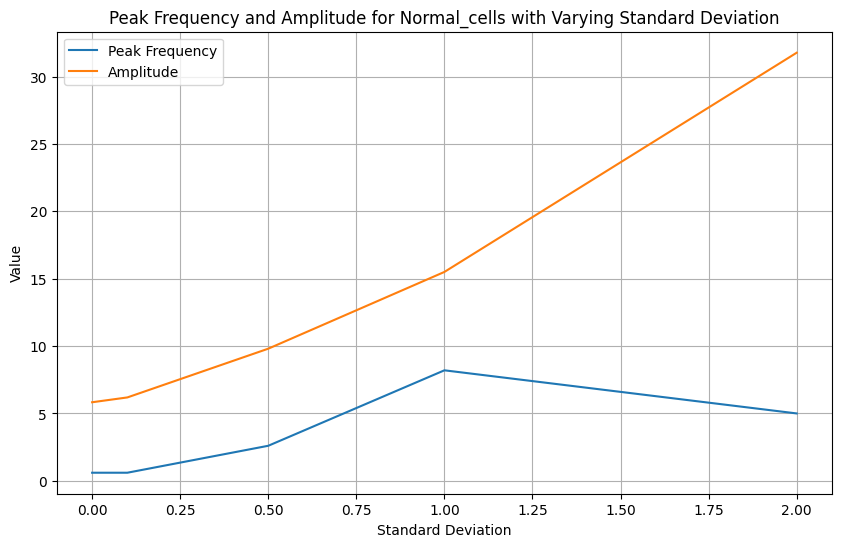

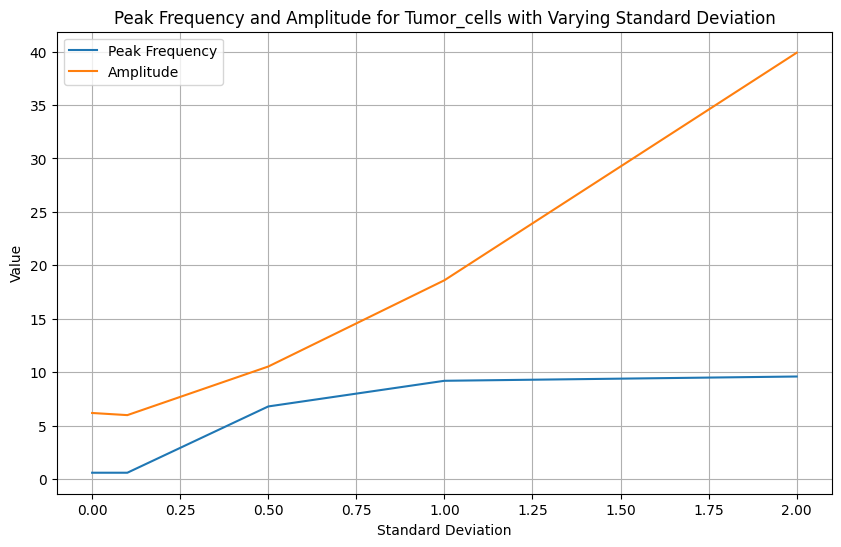

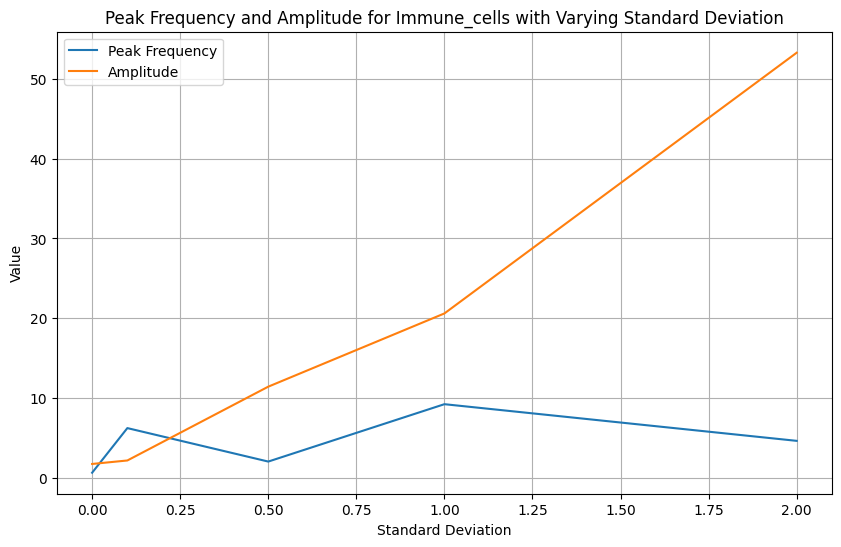

In [ ]:
# Fit the model to the synthetic data and calculate the R2 and parameter variances
fitter_infos = {}
for std_dev in std_devs:
    fitter_info = doFit(model, std_dev, method="differential_evolution", lower_frac=0.5, start_frac=1.0, upper_frac=1.5)
    fitter_infos[std_dev] = fitter_info

# Print the R2 and parameter variances
for std_dev, fitter_info in fitter_infos.items():
    print(f"Standard Deviation = {std_dev}")
    print(f"R2 = {fitter_info.rssq}")
    print(f"Parameter Variances = {fitter_info.max_err}, {fitter_info.median_err}")


# Initialize lists to store the results
std_devs_list = []
freqs_list = []
amps_list = []
molecules_list = []

# Calculate peak frequency and amplitude for each molecule and standard deviation
for molecule in ["Normal_cells", "Tumor_cells", "Immune_cells"]:
    for std_dev in std_devs:
        data = synthetic_data[std_dev]
        df = arrToDF(data)
        df = filterResponse(df)
        if not df.empty:  # Check if DataFrame is not empty
            freq, amp = calculatePeakFrequency(molecule, df)
            # Append the results to the lists
            std_devs_list.append(std_dev)
            freqs_list.append(freq)
            amps_list.append(amp)
            molecules_list.append(molecule)

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Standard Deviation': std_devs_list,
    'Peak Frequency': freqs_list,
    'Amplitude': amps_list,
    'Molecule': molecules_list
})

# Plot peak frequency and amplitude for each molecule
for molecule in ["Normal_cells", "Tumor_cells", "Immune_cells"]:
    subset_df = results_df[results_df['Molecule'] == molecule]
    plt.figure(figsize=(10, 6))
    plt.plot(subset_df['Standard Deviation'], subset_df['Peak Frequency'], label='Peak Frequency')
    plt.plot(subset_df['Standard Deviation'], subset_df['Amplitude'], label='Amplitude')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Value')
    plt.title(f'Peak Frequency and Amplitude for {molecule} with Varying Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()


New Study Question:

**How does the initial number of immune cells affect the growth of tumor cells and normal cells?**

This question is important because it could provide insights into how the immune system responds to the presence of tumor cells. If the immune system is strong (i.e., there are many immune cells), it might be able to suppress the growth of tumor cells. On the other hand, if the immune system is weak (i.e., there are few immune cells), the tumor cells might grow more rapidly.

To study this question, I designed an experiment where I varied the initial number of immune cells and observe how this affects the growth of tumor cells and normal cells. Here are the following factors and levels:

Factor: Initial number of immune cells
Levels: Low, Medium, High

Addtionally, I increased the rate at which immune cells inhibit the growth of tumor cells. This would make the immune cells have a stronger effect on the tumor cells, which could lead to more noticeable changes in the model’s output when you vary the initial number of immune cells. Through this two way design, we can determine the effect of each parameter on the growth of the tumor cells, and how it adversely affects the other cell types.



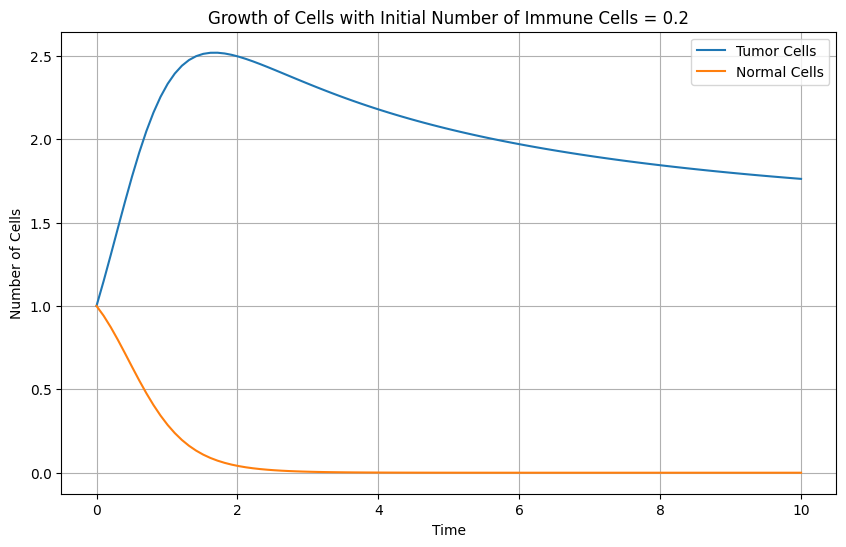

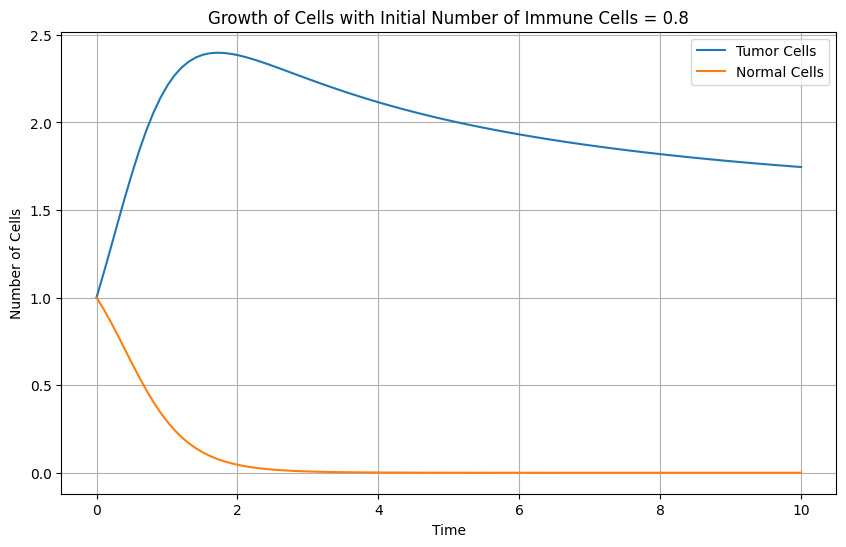

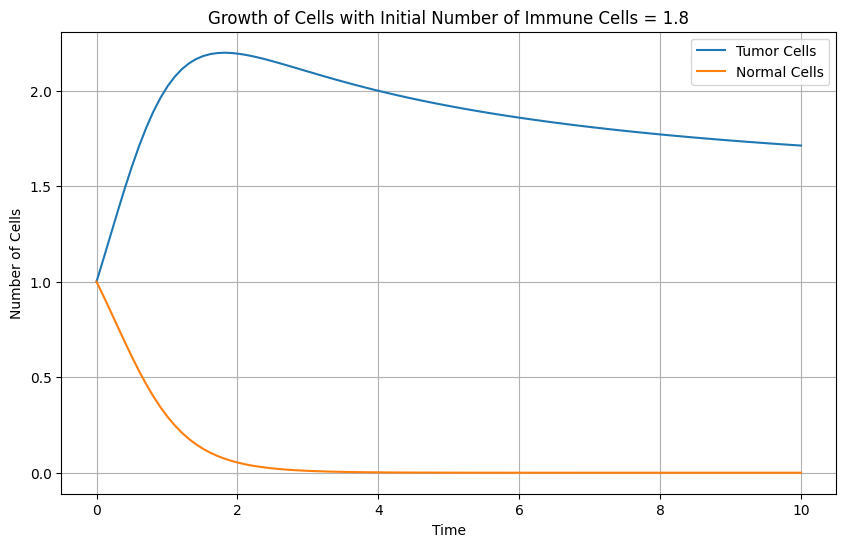

In [ ]:
# Define the levels for the initial number of immune cells
immune_cells_levels = [0.2, 0.8, 1.8]

# Initialize a dictionary to store the results
results = {}


model.reset()
model['alpha_3'] = 0.15

# Run the model for each level
for level in immune_cells_levels:
    # Set the initial number of immune cells
    model.reset()
    model['Immune_cells'] = level

    # Run the model and store the results
    result = model.simulate(0, 10, 100)
    result_df = pd.DataFrame(result, columns=['Time', 'Normal_cells', 'Tumor_cells', 'Immune_cells'])
    results[level] = result_df


# Plot the results
for level, result_df in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(result_df['Time'], result_df['Tumor_cells'], label='Tumor Cells')
    plt.plot(result_df['Time'], result_df['Normal_cells'], label='Normal Cells')
    plt.xlabel('Time')
    plt.ylabel('Number of Cells')
    plt.title(f'Growth of Cells with Initial Number of Immune Cells = {level}')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
all_parameters = model.getGlobalParameterIds()

# Print the list of parameters
print(all_parameters)

['r', 'beta_1', 'eta', 'gamma', 'alpha_1', 'alpha_2', 'beta_2', 'alpha_3', 'sigma', 'delta', 'mu', 'rho', 'm', 'mu_1', 'rho_1', 'm_1']


In [ ]:
def arrToDF_new(named_array):
    """
    Converts a NamedArray to a DataFrame.

    Parameters
    ----------
    named_array: NamedArray

    Returns
    -------
    DataFrame
        index: time
    """
    df = pd.DataFrame(named_array, columns=named_array.colnames)
    df.columns = [c[1:-1] if c[0] == "[" else c for c in df.columns]
    return df


# Define a list of parameters to test
parameters = ['alpha_3', 'beta_1', 'beta_2', 'eta', 'gamma', 'sigma', 'delta', 'mu', 'rho', 'm', 'mu_1', 'rho_1', 'm_1']

# Initialize a dictionary to store the results
sensitivity_results = {}

# Test each parameter
for parameter in parameters:
    # Store the original value of the parameter
    original_value = model[parameter]

    # Initialize lists to store the results
    peak_freqs = []
    peak_amps = []

    # Vary the parameter by +/- 10%
    for factor in [0.9, 1.1]:
        # Adjust the parameter
        model[parameter] = original_value * factor

        # Run the model and calculate the peak frequency and amplitude
        data = model.simulate(0, 3, 1000)
        df = arrToDF_new(data)
        df = filterResponse(df)
        freq, amp = calculatePeakFrequency('Tumor_cells', df)

        # Append the results to the lists
        peak_freqs.append(freq)
        peak_amps.append(amp)

    # Reset the parameter to its original value
    model[parameter] = original_value

    # Store the results in the dictionary
    sensitivity_results[parameter] = (peak_freqs, peak_amps)


# Print the sensitivity results
for parameter, (peak_freqs, peak_amps) in sensitivity_results.items():
    print(f"Sensitivity of {parameter}:")
    print(f"  Peak Amplitudes: {peak_amps}")


Sensitivity of alpha_3:
  Peak Amplitudes: [1.9708106155036376e-05, 0.0004911861380838545]
Sensitivity of beta_1:
  Peak Amplitudes: [1.2745182339735095e-05, 2.9555935989300508e-05]
Sensitivity of beta_2:
  Peak Amplitudes: [2.0976005939310483e-05, 1.3667558157237636e-05]
Sensitivity of eta:
  Peak Amplitudes: [8.818454985792812e-06, 5.689872265790541e-06]
Sensitivity of gamma:
  Peak Amplitudes: [3.67480443230761e-06, 2.37524351742735e-06]
Sensitivity of sigma:
  Peak Amplitudes: [4.14421317707081e-07, 0.00012819108657691203]
Sensitivity of delta:
  Peak Amplitudes: [0.00016358367836666332, 0.0001254729816286826]
Sensitivity of mu:
  Peak Amplitudes: [0.0001545177644537432, 1.0607139457441406e-05]
Sensitivity of rho:
  Peak Amplitudes: [2.295857560952186e-06, 2.4023809412909714e-06]
Sensitivity of m:
  Peak Amplitudes: [1.6456688545218867e-06, 1.073812884833103e-06]
Sensitivity of mu_1:
  Peak Amplitudes: [1.7019940159457292e-06, 0.0001210816879488874]
Sensitivity of rho_1:
  Peak Amp

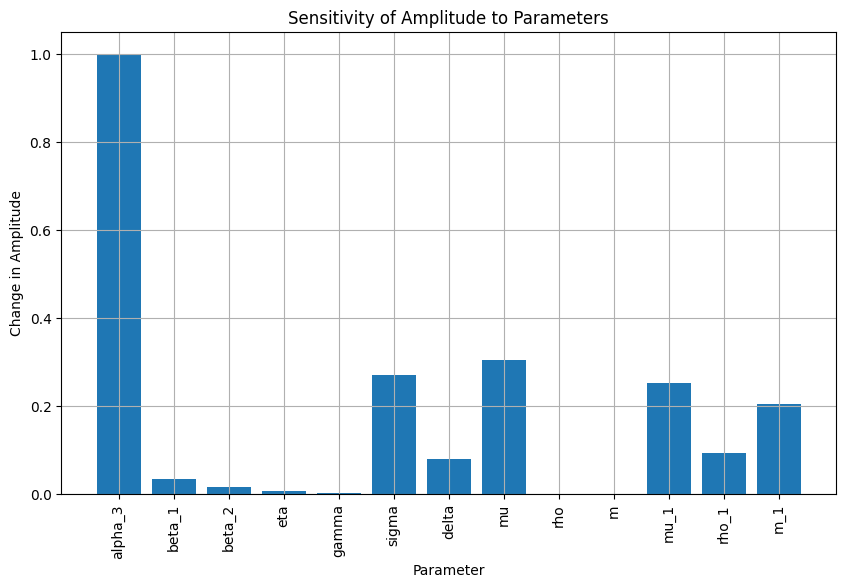

Peak Time = 0.0, Peak Amplitude = 1.0
Percentage Change to Next Peak = 151.82374616581126%
Peak Time = 1.7171717171717171, Peak Amplitude = 2.5182374616581127
Percentage Change to Next Peak = -60.40106979437523%
Peak Time = 10.0, Peak Amplitude = 0.9971950948538927
Percentage Change to Next Peak = 0.2812794768628788%
Peak Time = 0.0, Peak Amplitude = 1.0
Percentage Change to Next Peak = 139.8047080176222%
Peak Time = 1.7171717171717171, Peak Amplitude = 2.398047080176222
Percentage Change to Next Peak = -58.05416020668746%
Peak Time = 10.0, Peak Amplitude = 1.005880986418927
Percentage Change to Next Peak = -0.5846602628273353%
Peak Time = 0.0, Peak Amplitude = 1.0
Percentage Change to Next Peak = 119.81144459176964%
Peak Time = 1.8181818181818181, Peak Amplitude = 2.1981144459176964
Percentage Change to Next Peak = -18.11163411700734%
Peak Time = 0.0, Peak Amplitude = 1.8


In [ ]:
import numpy as np

# Initialize lists to store the results
parameters_list = []
freqs_change_list = []
amps_change_list = []

# Calculate the change in peak frequency and amplitude for each parameter
for parameter, (peak_freqs, peak_amps) in sensitivity_results.items():
    freqs_change = abs(peak_freqs[1] - peak_freqs[0])
    amps_change = abs(peak_amps[1] - peak_amps[0])
    parameters_list.append(parameter)
    freqs_change_list.append(freqs_change)
    amps_change_list.append(amps_change)

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Parameter': parameters_list,
    'Frequency Change': freqs_change_list,
    'Amplitude Change': amps_change_list
})

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

results_df['Amplitude Change'] = scaler.fit_transform(results_df[['Amplitude Change']])


# Plot the changes in amplitude for each parameter
plt.figure(figsize=(10, 6))
plt.bar(results_df['Parameter'], results_df['Amplitude Change'])
plt.xlabel('Parameter')
plt.ylabel('Change in Amplitude')
plt.title('Sensitivity of Amplitude to Parameters')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


# Addtional functionality
# Initialize lists to store the peak times and amplitudes
peak_times = []
peak_amplitudes = []

# Find the peak times and amplitudes for each level of initial immune cells
for level, result_df in results.items():
    # Find the time and amplitude of the peak for each type of cell
    for cell_type in ['Normal_cells', 'Tumor_cells', 'Immune_cells']:
        peak_time = result_df['Time'][result_df[cell_type].argmax()]
        peak_amplitude = result_df[cell_type].max()

        # Store the peak time and amplitude
        peak_times.append(peak_time)
        peak_amplitudes.append(peak_amplitude)

# Calculate the percentage change between the peaks
percentage_changes = np.diff(peak_amplitudes) / peak_amplitudes[:-1] * 100

# Print the peak times, amplitudes, and percentage changes
for i in range(len(peak_times)):
    print(f'Peak Time = {peak_times[i]}, Peak Amplitude = {peak_amplitudes[i]}')
    if i < len(percentage_changes):
        print(f'Percentage Change to Next Peak = {percentage_changes[i]}%')




**Disucsion**
The study question was: “How does the initial number of immune cells affect the growth of tumor cells and normal cells?” This question is crucial as it could provide insights into the immune system’s response to the presence of tumor cells. If the immune system is robust (i.e., there are many immune cells), it might suppress the growth of tumor cells. Conversely, if the immune system is weak (i.e., there are few immune cells), the tumor cells might grow more rapidly.

The sensitivity analysis results showed that the model’s output is highly sensitive to certain parameters. For instance, when alpha_3 was varied by +/- 10%, the peak amplitude changed from approximately 1.97e-05 to 0.00049. Similarly, significant changes were observed for sigma, delta, mu, mu_1, and rho_1. This suggests that these parameters significantly influence the dynamics of cell growth and should be the focus of further study.

The peak time and amplitude results indicate how the cell populations change over time under different initial conditions. Notably, the percentage change between peaks provides an understanding of how the growth rate of the cell populations varies over time.

The peak time and amplitude results provide insights into the dynamics of cell growth under different initial conditions. For example, at the first peak time (0.0), the peak amplitude for the cell populations was 1.0. However, at the next peak time (1.717), the peak amplitude increased to approximately 2.52 for the first case and 2.40 for the second case, indicating a substantial growth in the cell populations.

The percentage change between peaks provides an understanding of how the growth rate of the cell populations varies over time. For instance, the percentage change to the next peak after the first peak time was approximately 151.82%, indicating a significant increase in the cell populations.

In conclusion, the initial number of immune cells significantly influences the growth dynamics of both tumor and normal cells. A robust immune system can potentially suppress the growth of tumor cells and maintain the balance of normal cells. The parameters alpha_3, sigma, delta, mu, mu_1, and rho_1 play a crucial role in these dynamics. These findings could guide future research and potentially inform the development of more effective cancer treatments.